## This notebook demonstrates how to run MassWastingRunout for the S-1000, 2022 landslide

In [1]:
# setup
import os

## import plotting tools
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

## import necessary landlab components
from landlab import RasterModelGrid
from landlab.components import FlowAccumulator
from landlab.components import(FlowDirectorD8, 
                                FlowDirectorDINF, 
                                FlowDirectorMFD, 
                                FlowDirectorSteepest)

from landlab.components.mass_wasting_router import MassWastingRunout

## import landlab plotting functionality
from landlab.plot.drainage_plot import drainage_plot
from landlab import imshow_grid_at_node

## import functions
from landlab.io.esri_ascii import write_esri_ascii
from landlab.io import read_esri_ascii
from landlab.io.netcdf import read_netcdf

from landlab.components import ChannelProfiler, FlowAccumulator, DepressionFinderAndRouter

os.chdir('C:/Users/keckje/Documents/GitHub/code/landlab/LandlabTools')
import LandlabTools as LLT


os.chdir('C:/Users/keckje/Documents/GitHub/code/preevents/paper2/')
import MassWastingRunoutEvaluationFunctions as MWF

In [2]:
### script and model controls

In [3]:
movie = False
save_movie = False    
svnm = 's1000_22_2000_10m'
save_demdif = False
demdifnm = 's1000_22_'
# file location where output will be saved
wdir = 'D:/UW_PhD/PreeventsProject/Paper_2_MWR/Writeup/Figures/S1000_22_validation/'
# figure domain
mvx = 70200; mvx_ = 71175
mvy = 361100; mvy_ = 361600

#%% model controls
mw_id = 1
UseSoilDepth = True
t_avg = 15
vary_cs = False
qsc_constraint = True
method = "both"
routing_surface = "topographic__elevation"
deposition_rule = "critical_slope"
deposit_style = 'downslope_deposit_sc10'
effective_qsi = True
qsi_max = 5
g_erosion = True
settle_deposit = False
# lower and upper elevations used to determine profile fit to data
el_l = 230
el_h = 430


### prep model inputs

C:\Users\keckje\Documents\GitHub\code\preevents\paper2\MassWastingRunoutEvaluationFunctions.py:1087: UserWarning: The following kwargs were not used by contour: 'linewidth'
  CS = ax.contour(grid_x,grid_y,grid_z1,np.linspace(np.nanmin(grid_z1),np.nanmax(grid_z1),cntrs), colors='k', linewidth = 0.5)
C:\Users\keckje\Documents\GitHub\code\preevents\paper2\MassWastingRunoutEvaluationFunctions.py:1113: UserWarning: The following kwargs were not used by contour: 'linewidth'
  CS = ax.contour(grid_x,grid_y,grid_z1,np.linspace(np.nanmin(grid_z1),np.nanmax(grid_z1),cntrs), colors='k', linewidth = 0.5)


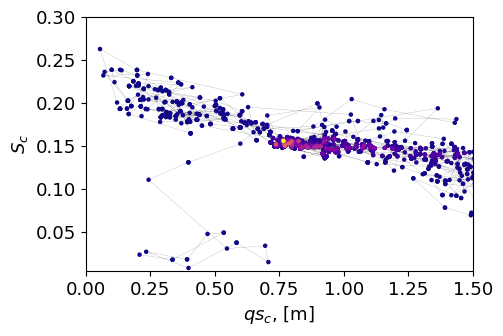

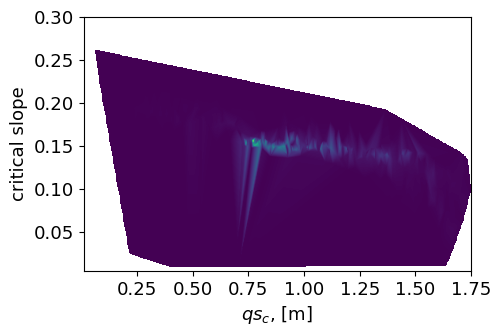

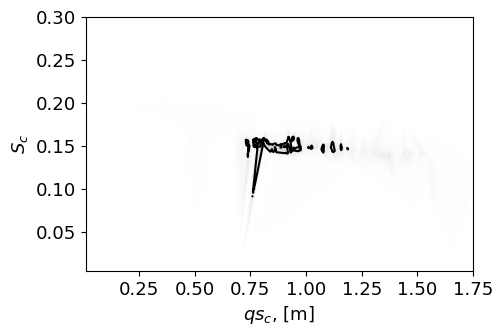

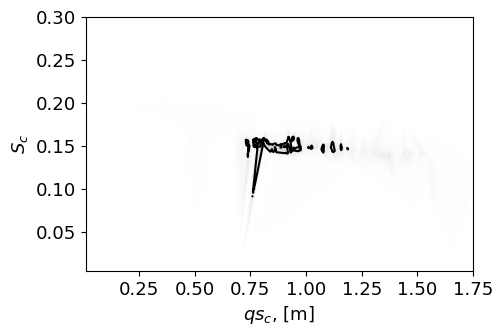

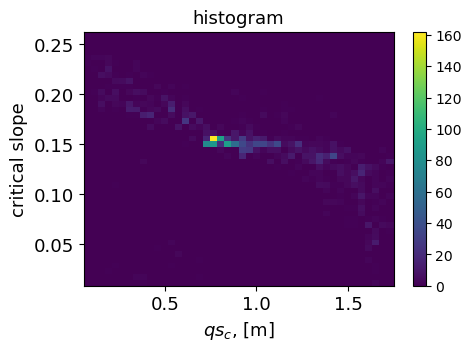

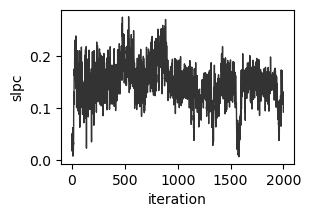

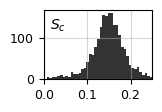

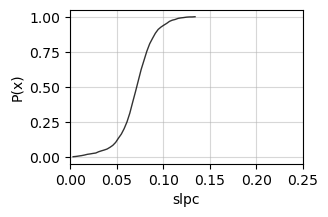

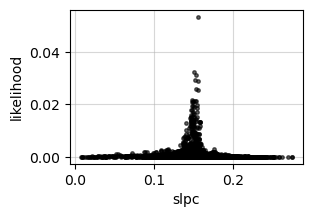

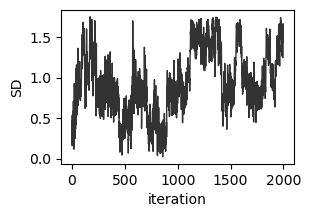

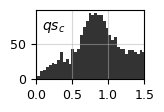

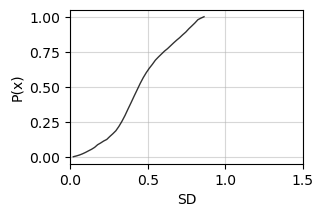

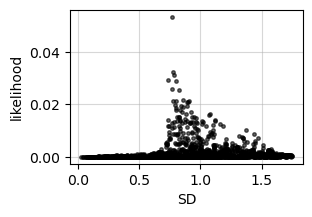

In [4]:
csvnm = 's1000_10m_2000_ns_nmcmc.csv'#s1000_10m_200_eta0d2__mcmc.csv'#'s1000_10m_2000_omega_eta0d2__mcmc.csv' #'s1000_22_2000_0d15_mcmc.csv'
# location of calibration output
mdir = 'D:/UW_PhD/PreeventsProject/Paper_2_MWR/RunoutValidation/S1000/output/MCMC_v1/'

results, best, sum_dict, params, mw_dict = MWF.calibration_results(mdir, csvnm, aspect = 'auto', fs = 13, cntrs = 6, figsize = (5,3.3),
                        save = True, svnm = svnm, wdir = wdir, labloc = [[0.05,0.75],[0.05,0.75]])  

mw_dict['critical slope'] = [best['candidate_value_slpc'].values[0]]
mw_dict['minimum flux'] = best['candidate_value_SD'].values[0]

release_dict = {'number of pulses':[1], 'iteration delay':[1] }

### prep model GIS inputs

In [5]:
# GIS generated inputs
bdfdem = '2019li_5m10m_xv2.asc' # before debris flow dem
lsnodes = 'ls_poly_v5_10m.asc' # landslide poligon nodes
bdfdem_hs = '2019li_2m_xv2_hs.asc' # before debris flow dem hs
odfdem = 'dif_10m_t7.asc' # observed dem difference

# cross section xlsx file name
xlsxm = 'ProfileNodes_10m.xlsx'

# GIS input file location
dem_dir = 'D:/UW_PhD/PreeventsProject/Paper_2_MWR/RunoutValidation/S1000/input/'
# cross section file location
xs_dir = 'D:/UW_PhD/PreeventsProject/Paper_2_MWR/RunoutValidation/S1000/maps/S1000/'

### load GIS inputs onto the grid, including the landslide polygon

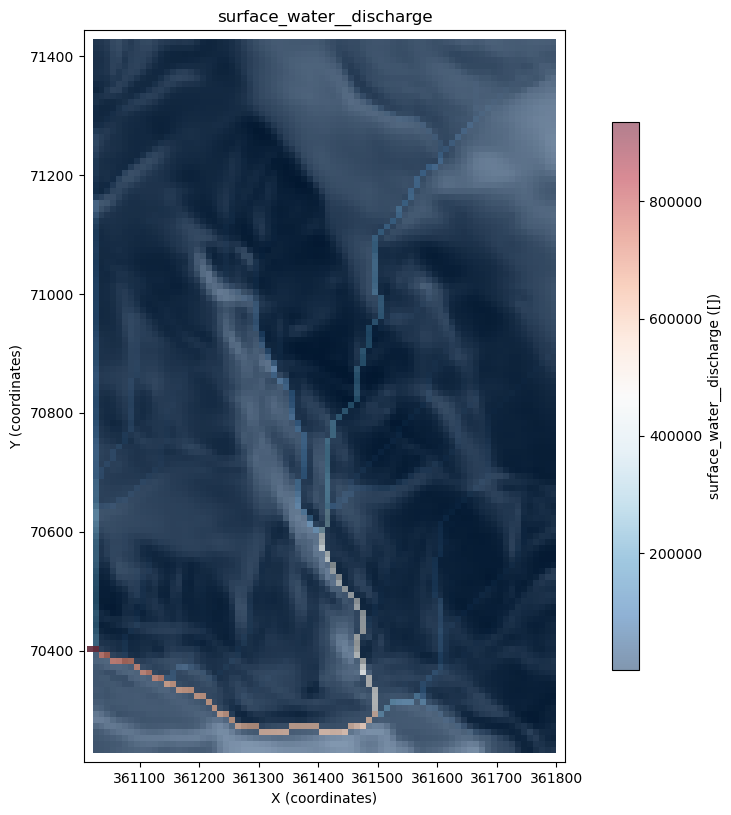

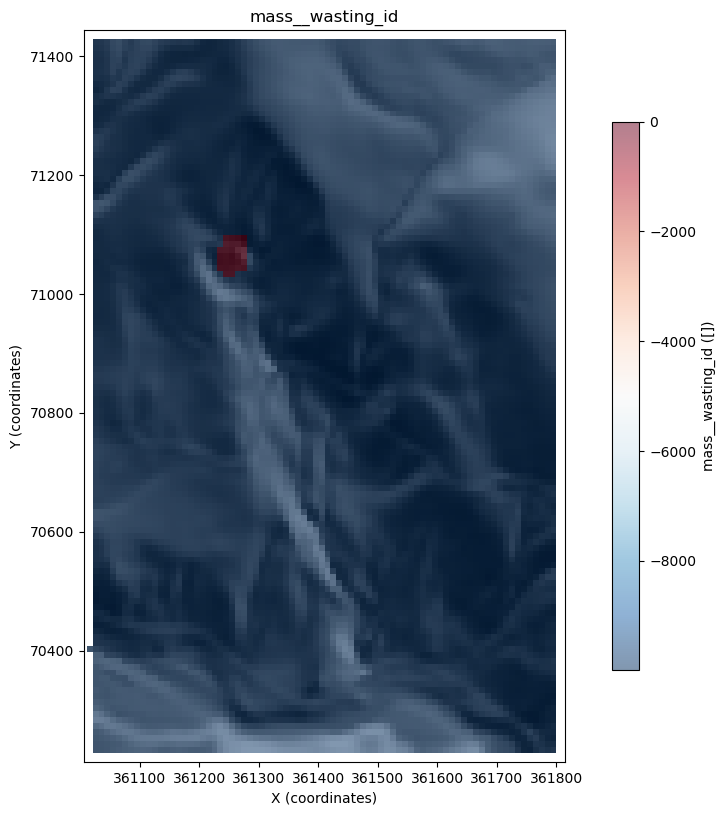

<Figure size 640x480 with 0 Axes>

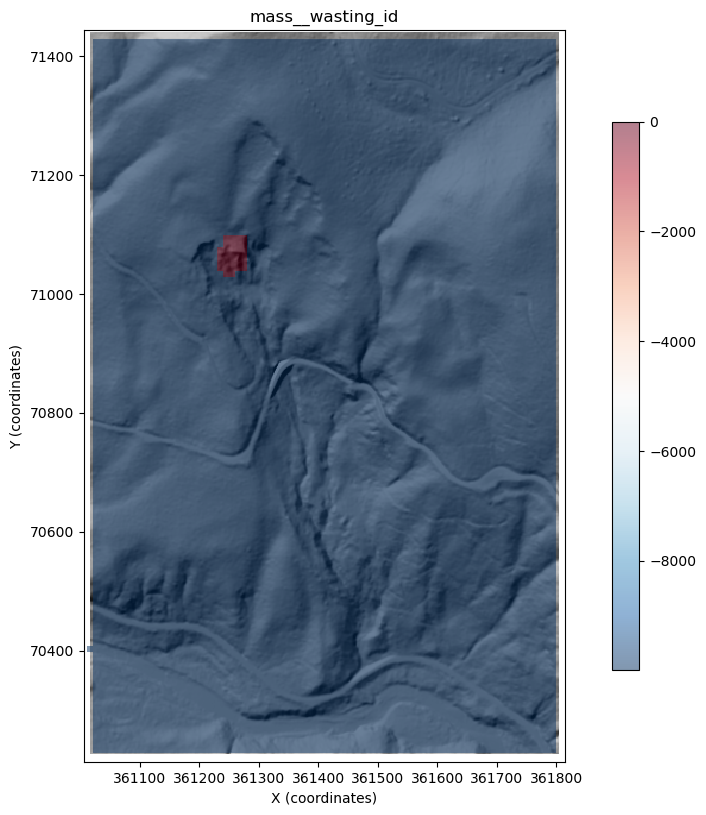

In [6]:
#%% load GIS inputs

# dem
mg, z = read_esri_ascii(dem_dir+bdfdem, name='topographic__elevation')

# ls nodes
_, mw1 = read_esri_ascii(dem_dir+lsnodes, name='mass__wasting_id')
mg.add_field('node', 'mass__wasting_id',mw1.astype(int))

# observed deposition
_, mw1 = read_esri_ascii(dem_dir+odfdem, name='dem_dif_o')
mg.add_field('node', 'dem_dif_o',mw1)
mg.at_node['dem_dif_o'][mg.at_node['dem_dif_o'] == -9999] = 0 # change null values to zero

# soil depth
# here using uniform depth
depth = np.ones(mg.at_node['topographic__elevation'].shape[0])*1.2
mg.add_field('node', 'soil__thickness',depth)


# for landslide, set depth equal to field estimated average depth
if UseSoilDepth is True:
    lsdepth = 'sd_s1000_v5_10m.asc' # dem difference inferred landslide depth, may need to increase depth at lower part of landslide
    _, lsd = read_esri_ascii(dem_dir+lsdepth, name='ls_depth')
    lsd = lsd[lsd != -9999]
    mg.at_node['soil__thickness'][mg.at_node['mass__wasting_id'] == mw_id] = -1*lsd
else:
    mg.at_node['soil__thickness'][mg.at_node['mass__wasting_id'] == mw_id] = t_avg
    
# high res hillshade for plot background
mg_hs, hs = read_esri_ascii(dem_dir+bdfdem_hs, name='hillshade')
mg_hs.at_node['hillshade_arc'] = hs
mg_hs.at_node['hillshade_arc'][mg_hs.at_node['hillshade_arc'] == -9999] = np.nan

mg.set_watershed_boundary_condition(z) # finds lowest point in dem and sets it as an open node

# add particle diameter
if g_erosion:
    mg.at_node['particle__diameter'] = np.ones(len(mg.node_x))*mw_dict['effective particle diameter']

# write nodes to ascii file for arcGIS, do this to get a copy of node id's into GIS
# write_esri_ascii(dem_dir+'mass__wasting_id.asc'.format(svnm), mg, 'mass__wasting_id')
#%% use DEM to create other needed fields

# flow accumulater to get contributing area to each grid cell
fa = FlowAccumulator(mg, 
                      'topographic__elevation',
                      flow_director='FlowDirectorD8')
fa.run_one_step()

# fill depressions to correct surface area determination
df_4 = DepressionFinderAndRouter(mg)
df_4.map_depressions()

# landlab built in hillshade
mg.at_node['hillshade'] = mg.calc_hillshade_at_node(elevs=z, alt=37., az=210.)
        
# visually check inputs
LLT.plot_node_field_with_shaded_dem(mg,field = 'surface_water__discharge', fontsize = 10,cmap = 'RdBu_r',alpha = .5)
LLT.plot_node_field_with_shaded_dem(mg,field = 'mass__wasting_id', fontsize = 10,cmap = 'RdBu_r',alpha = .5)
plt.figure()
LLT.plot_node_field_with_shaded_dem_Arc(mg, mg_hs = mg_hs, field = 'mass__wasting_id',plot_name = 'high_res', fontsize = 10,cmap = 'RdBu_r',alpha = .5)

# save an copy of the initial elevation for dem differencing
_ = mg.add_field('topographic__initial_elevation',
                    mg.at_node['topographic__elevation'],
                    at='node',
                    copy = True)

# multiflow direction for MWRu
# need to delete d8 flow direction
mg.delete_field(loc = 'node', name = 'flow__sink_flag')
mg.delete_field(loc = 'node', name = 'flow__link_to_receiver_node')
mg.delete_field(loc = 'node', name = 'flow__receiver_node')
mg.delete_field(loc = 'node', name = 'topographic__steepest_slope')

# run flow director, add slope and receiving node fields
fd = FlowDirectorMFD(mg, diagonals=True,
                      partition_method = 'slope')
fd.run_one_step()

### view the landslide polygon before releasing the landslide

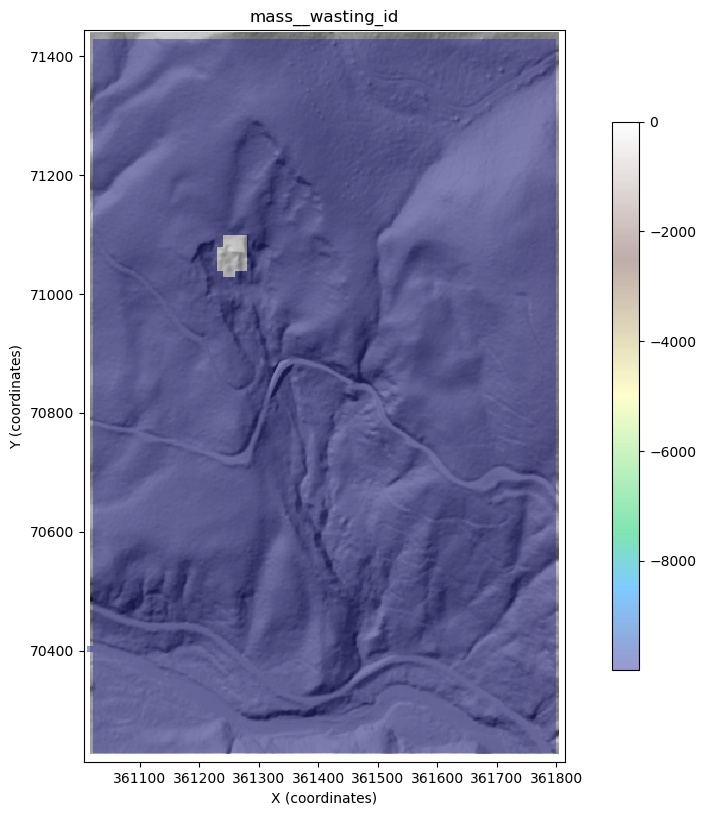

In [14]:
LLT.plot_node_field_with_shaded_dem_Arc(mg, mg_hs = mg_hs, field = 'mass__wasting_id',plot_name = 'high_res', fontsize = 10,alpha = .5)

### instantiate MassWastingRunout and run it!!!!

In [7]:
#%% set model parameters
DebrisFlows = MassWastingRunout(mg,release_dict,mw_dict, save = True,
                                veg_factor = 1,
                                dist_to_full_flux_constraint = 0,
                                routing_surface = routing_surface,
                                settle_deposit = settle_deposit,
                                deposition_rule = deposition_rule,
                                deposit_style = deposit_style,
                                effective_qsi = effective_qsi)
DebrisFlows.run_one_step(dt = 0)

 running with spatially variable Dp 
20
40
60
80


### visualize the runout

C:\Users\keckje\AppData\Local\Temp\ipykernel_24616\2317633695.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure('dif'+str(c)+str(i),figsize=(12, 12))


<Figure size 1200x1200 with 0 Axes>

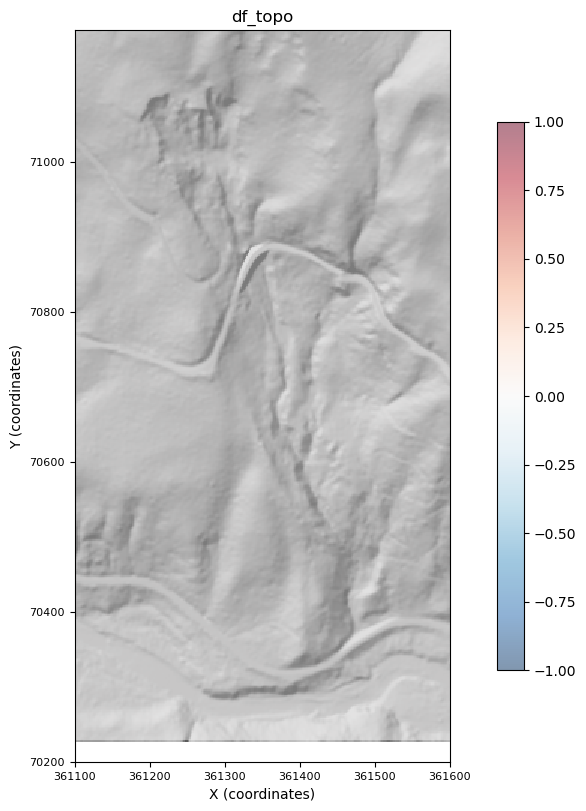

<Figure size 1200x1200 with 0 Axes>

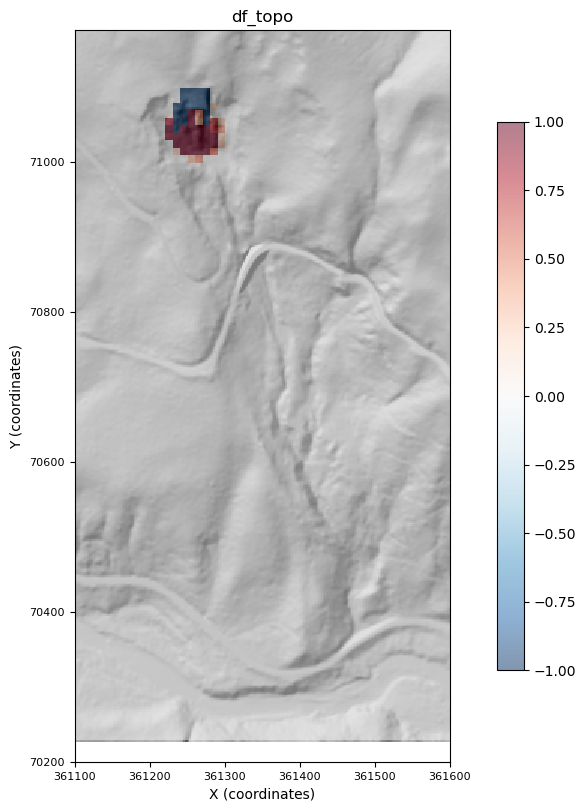

<Figure size 1200x1200 with 0 Axes>

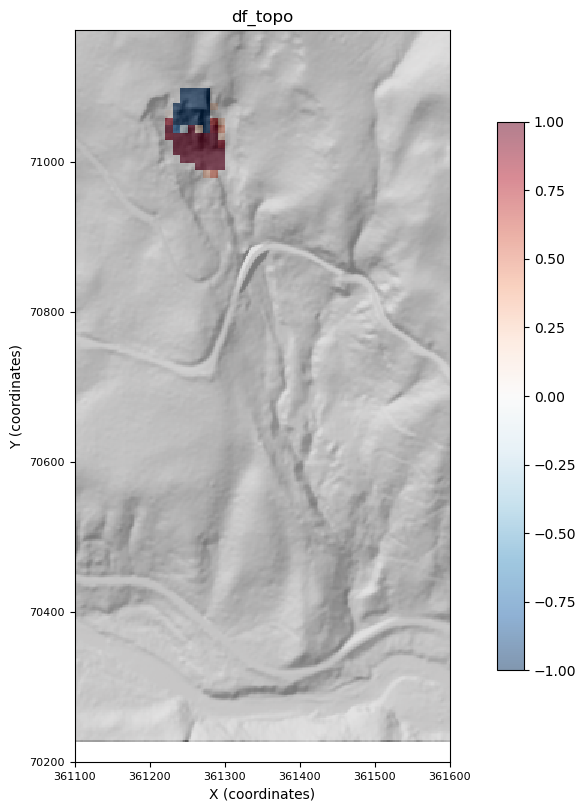

<Figure size 1200x1200 with 0 Axes>

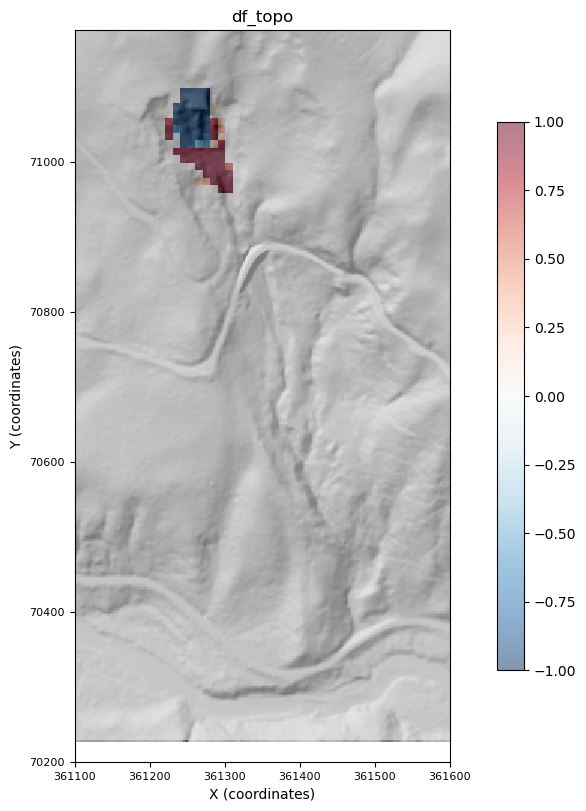

<Figure size 1200x1200 with 0 Axes>

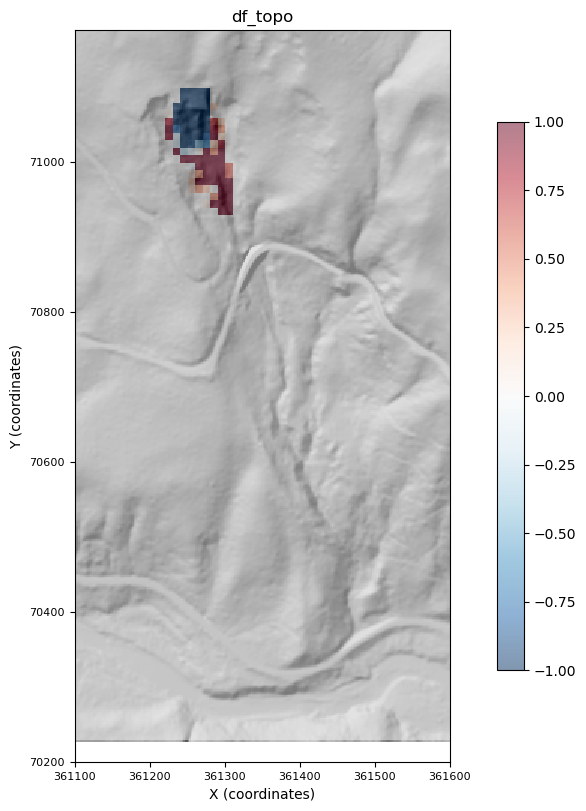

<Figure size 1200x1200 with 0 Axes>

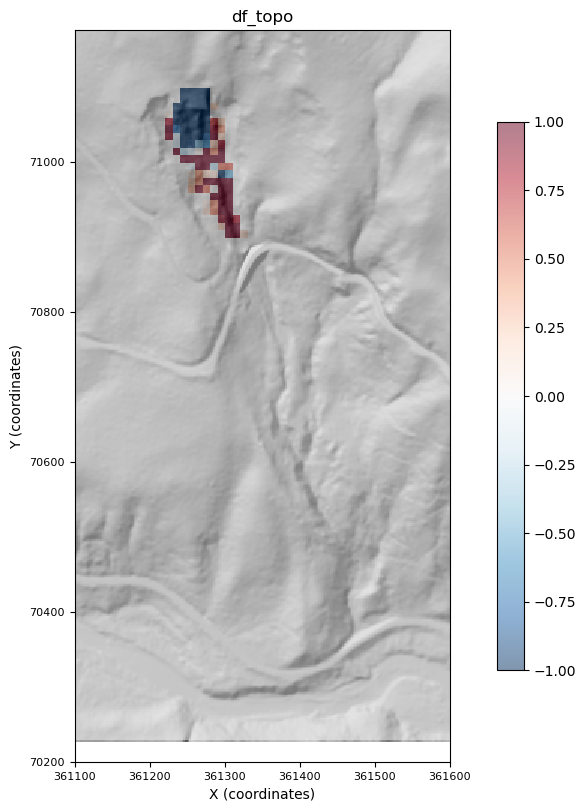

<Figure size 1200x1200 with 0 Axes>

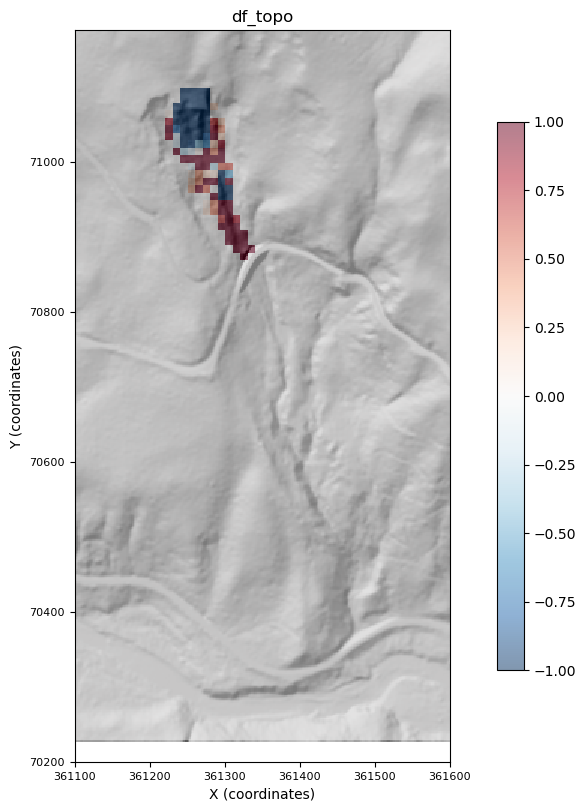

<Figure size 1200x1200 with 0 Axes>

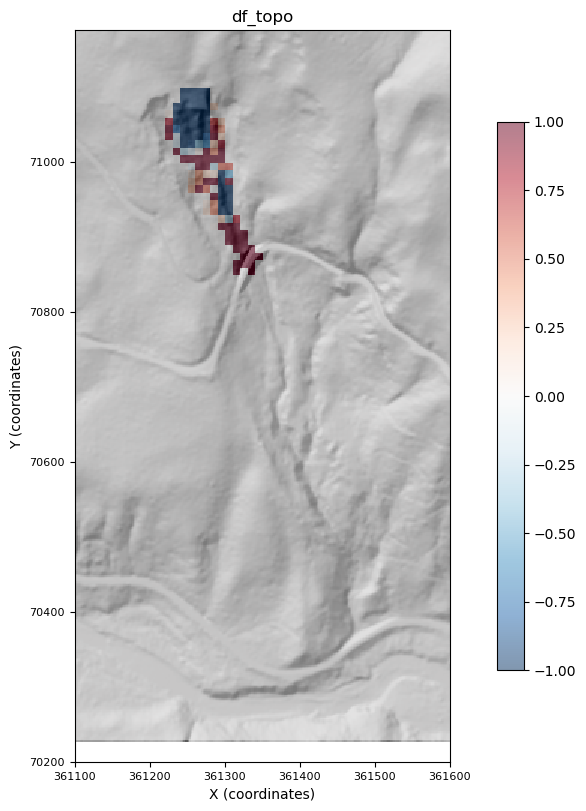

<Figure size 1200x1200 with 0 Axes>

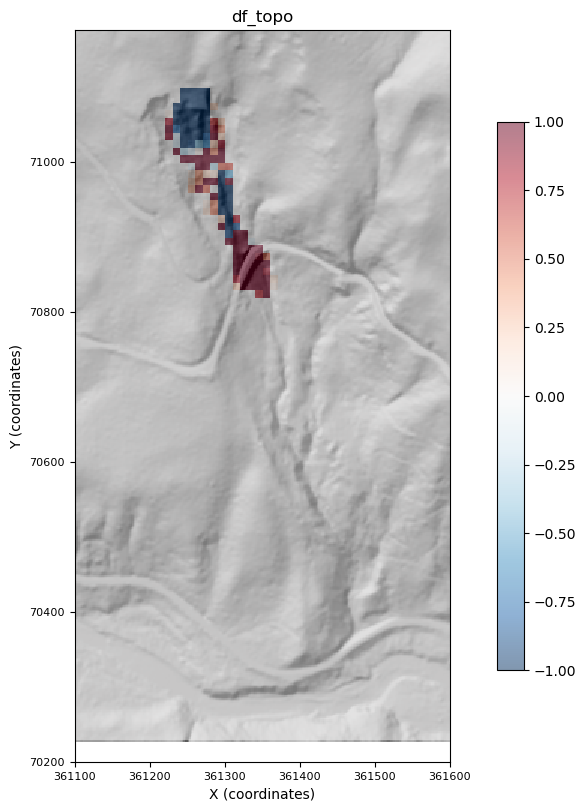

<Figure size 1200x1200 with 0 Axes>

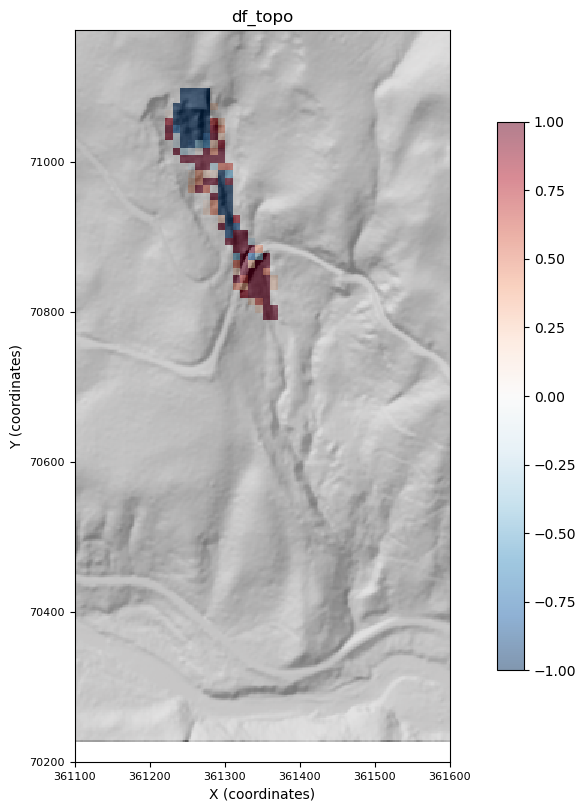

<Figure size 1200x1200 with 0 Axes>

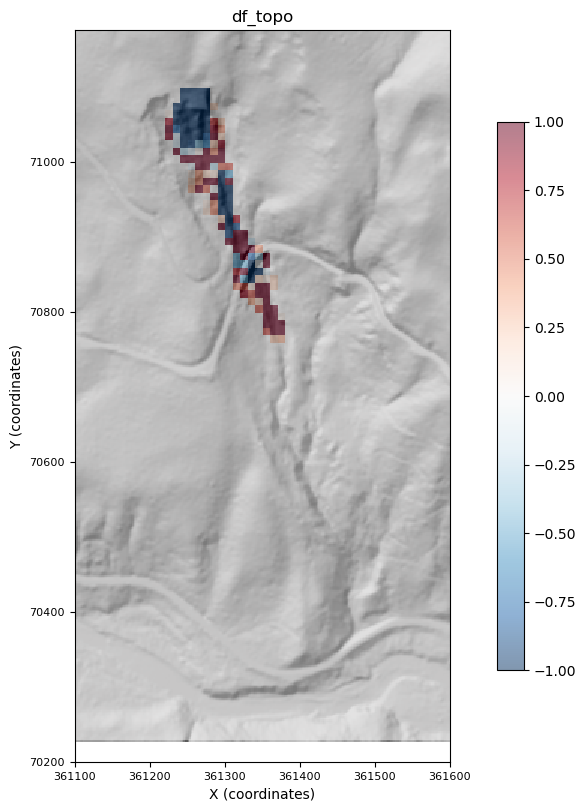

<Figure size 1200x1200 with 0 Axes>

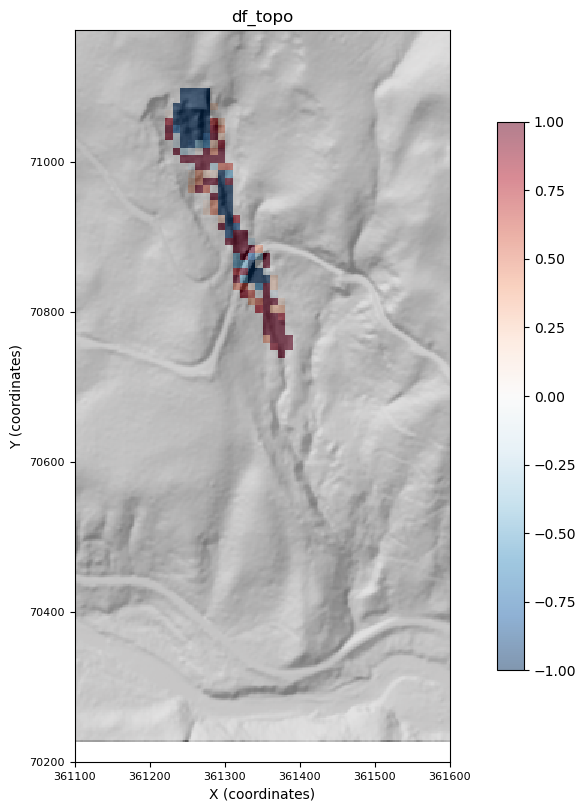

<Figure size 1200x1200 with 0 Axes>

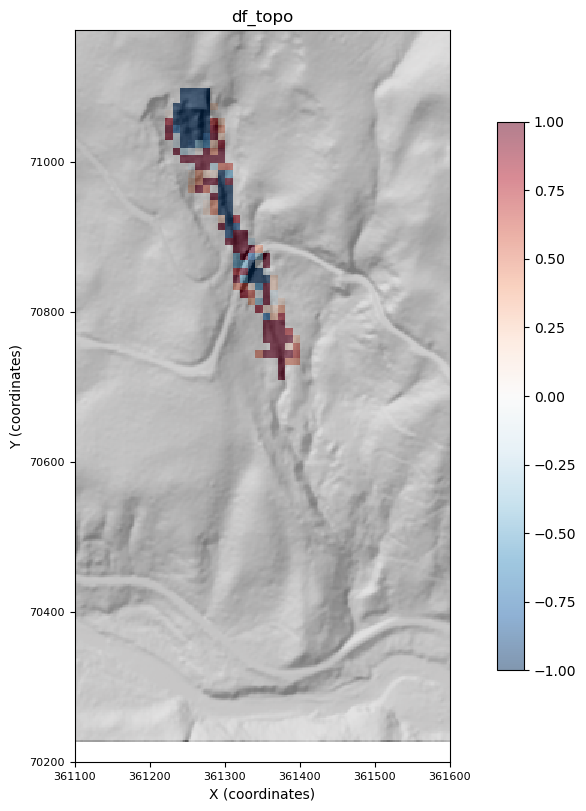

<Figure size 1200x1200 with 0 Axes>

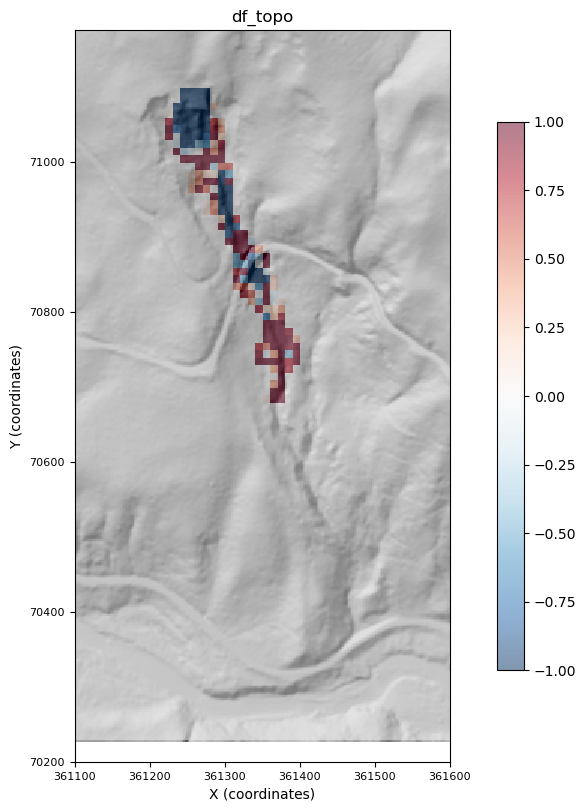

<Figure size 1200x1200 with 0 Axes>

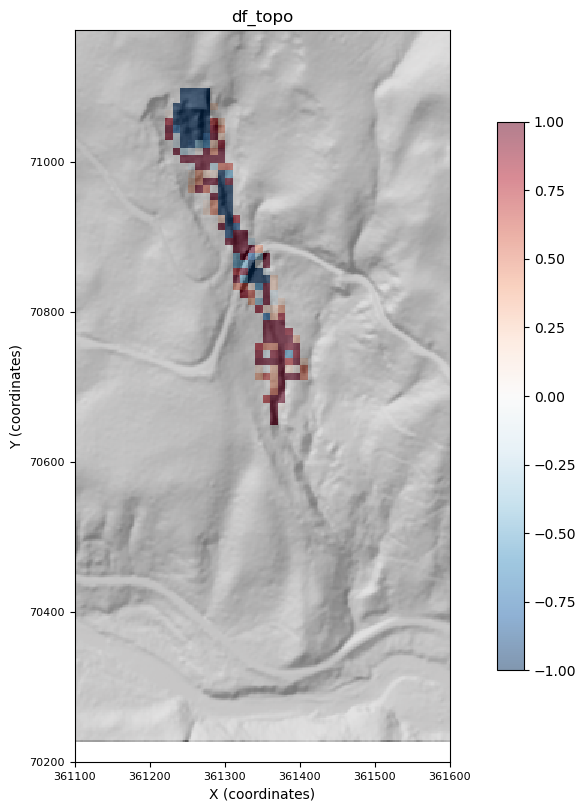

<Figure size 1200x1200 with 0 Axes>

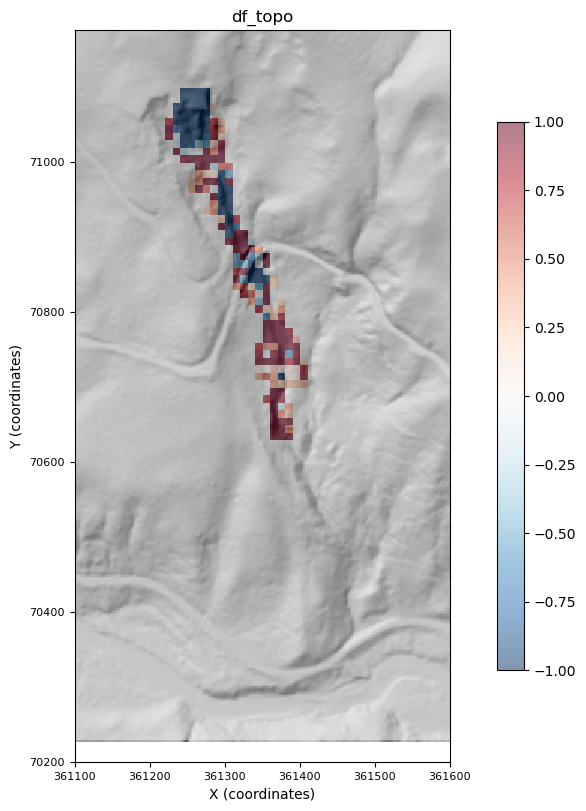

<Figure size 1200x1200 with 0 Axes>

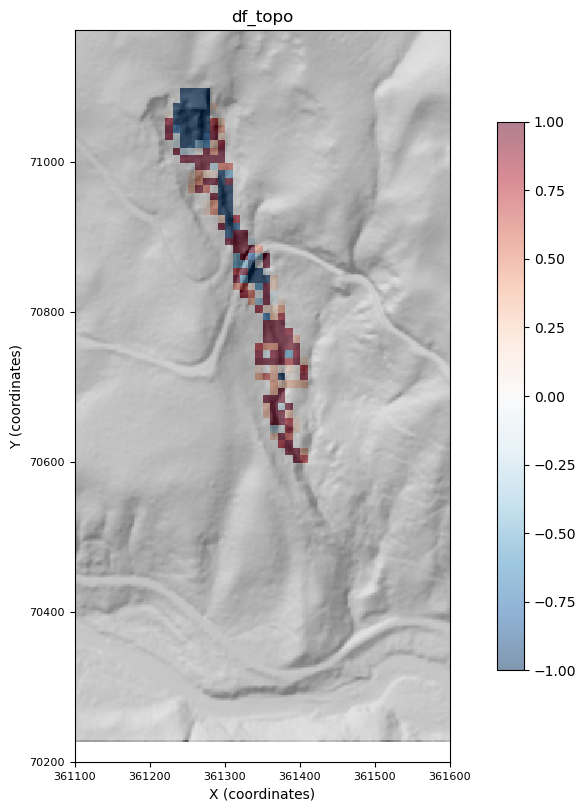

<Figure size 1200x1200 with 0 Axes>

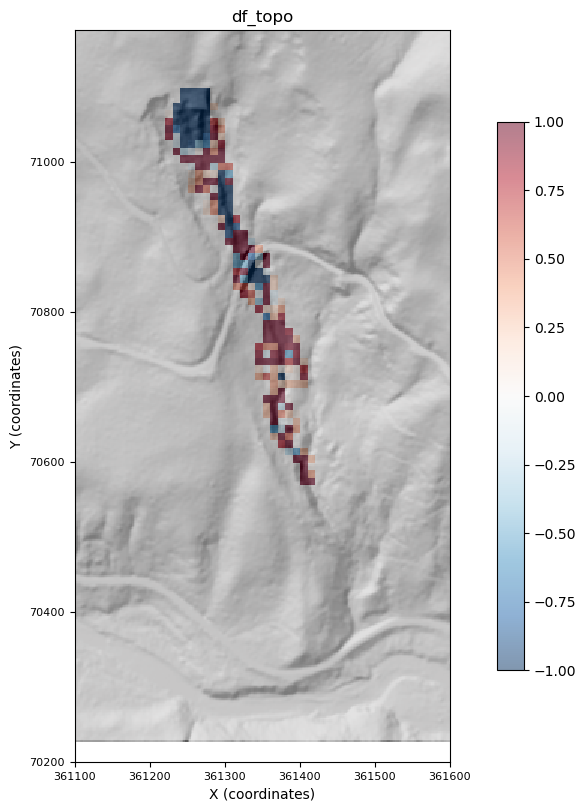

<Figure size 1200x1200 with 0 Axes>

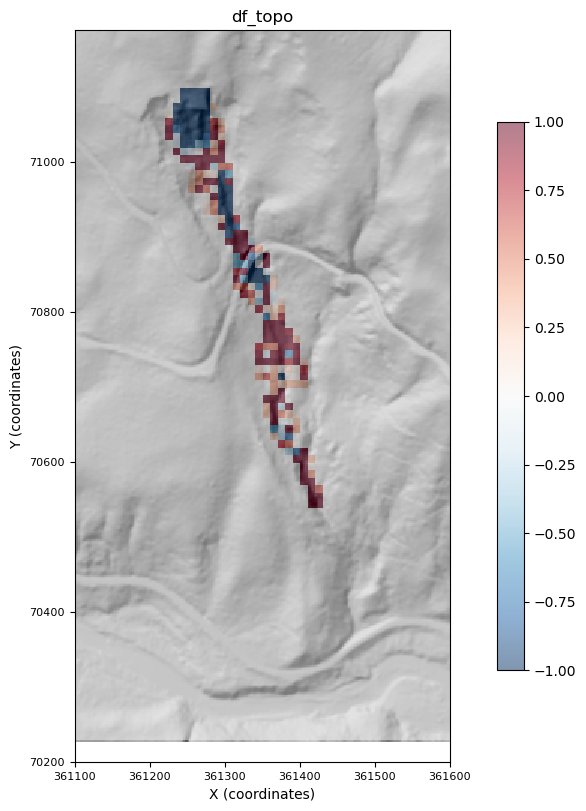

<Figure size 1200x1200 with 0 Axes>

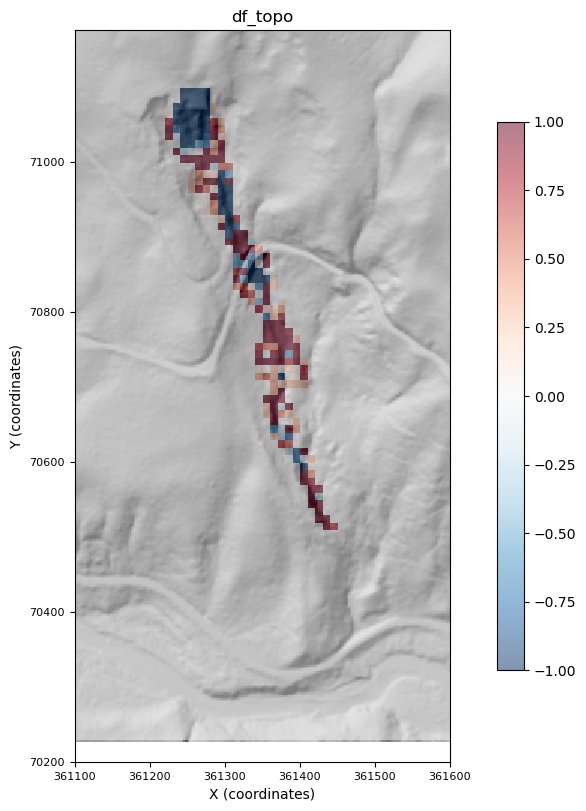

<Figure size 1200x1200 with 0 Axes>

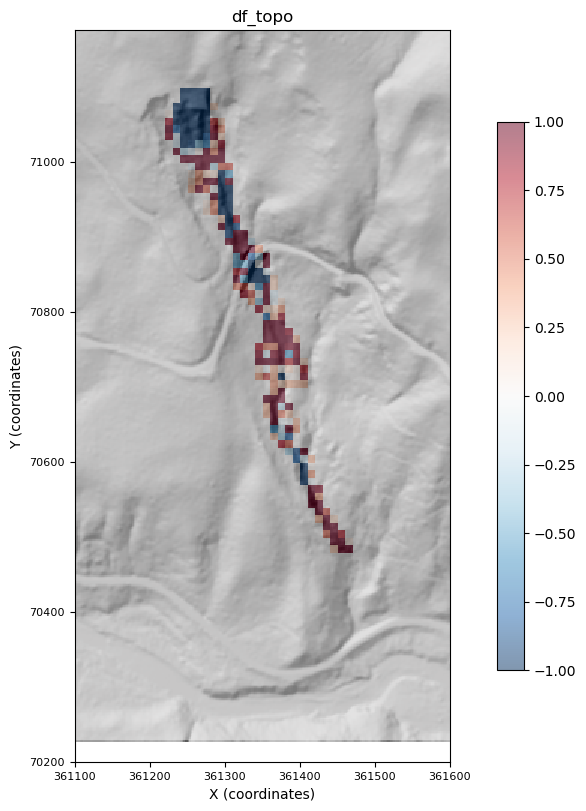

<Figure size 1200x1200 with 0 Axes>

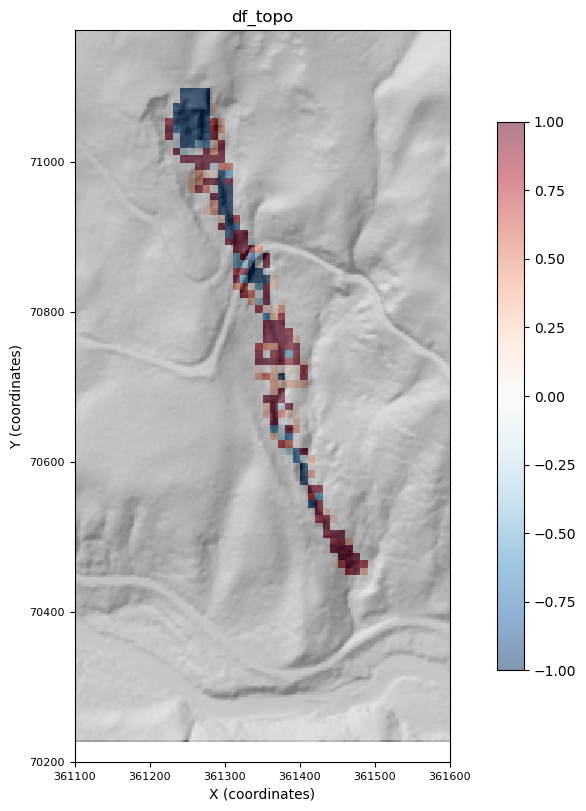

<Figure size 1200x1200 with 0 Axes>

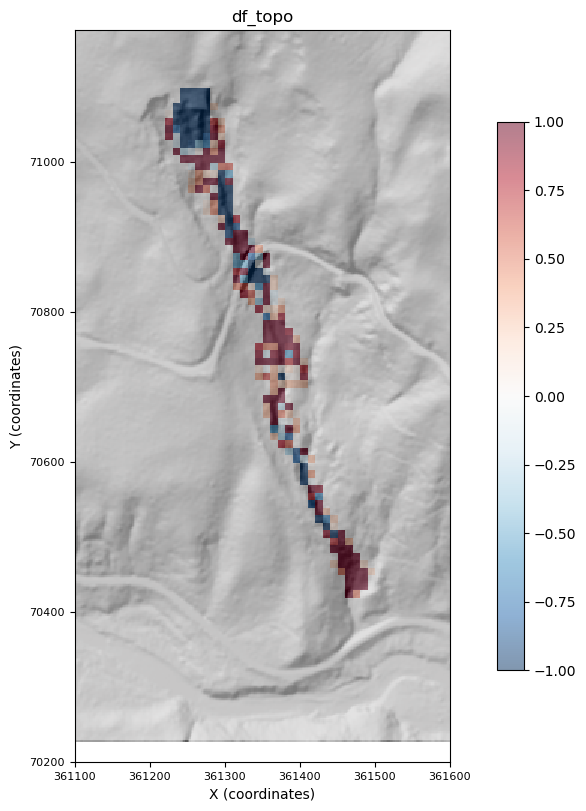

<Figure size 1200x1200 with 0 Axes>

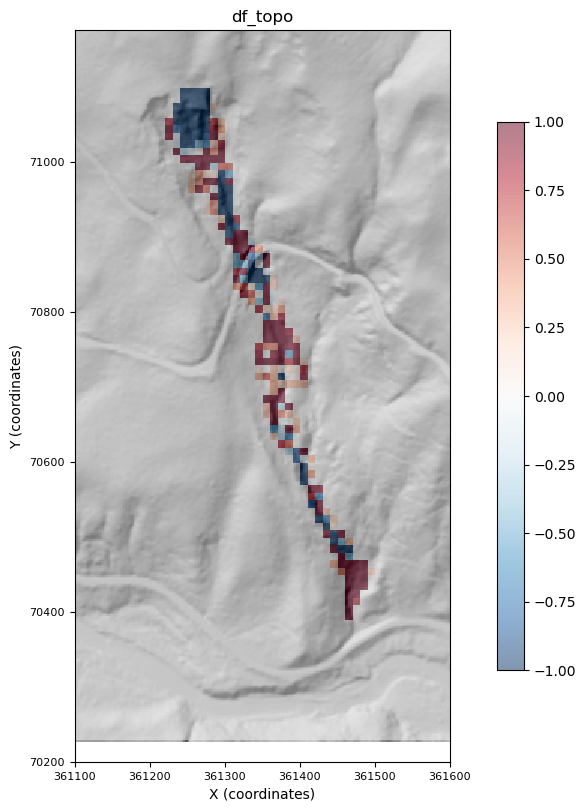

<Figure size 1200x1200 with 0 Axes>

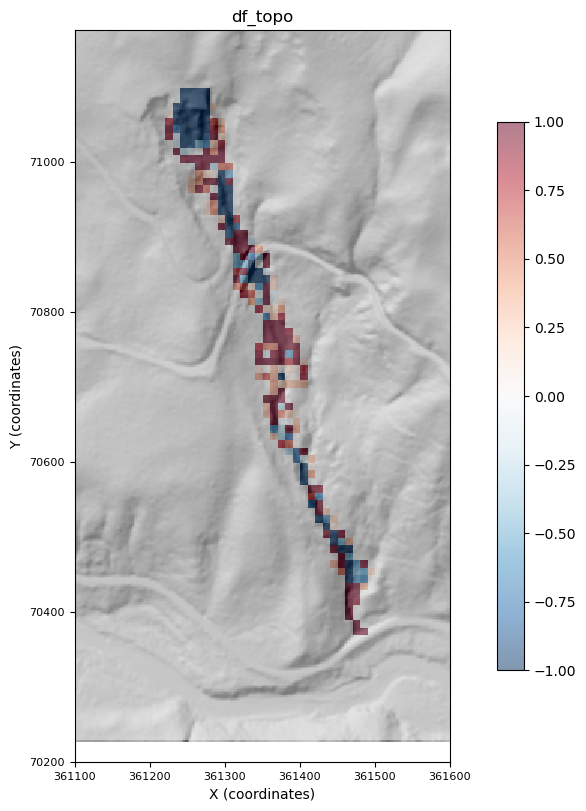

<Figure size 1200x1200 with 0 Axes>

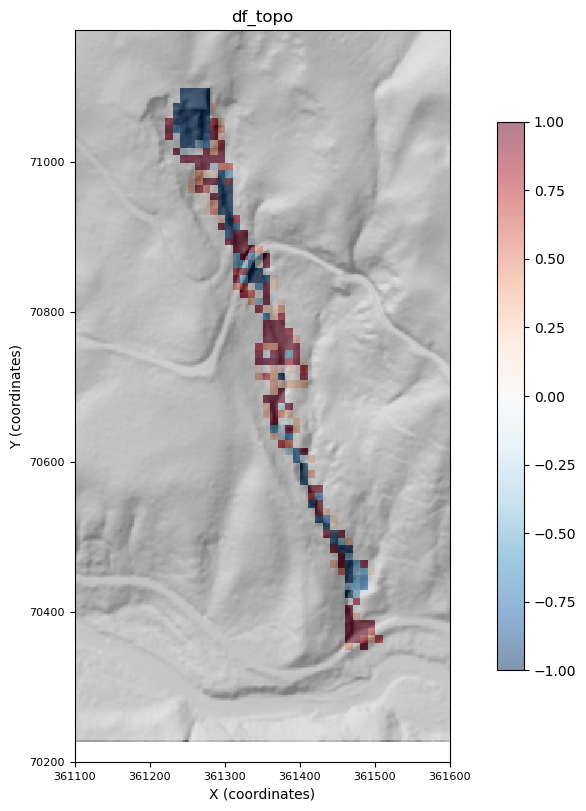

<Figure size 1200x1200 with 0 Axes>

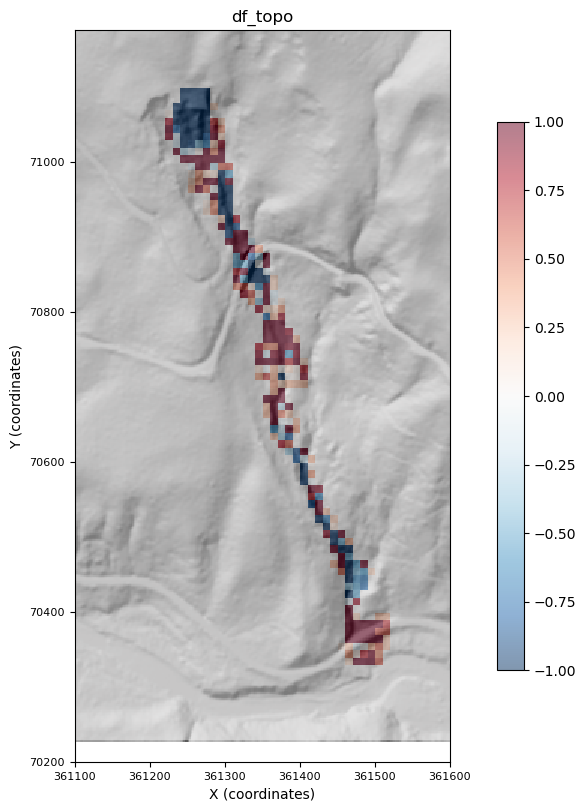

<Figure size 1200x1200 with 0 Axes>

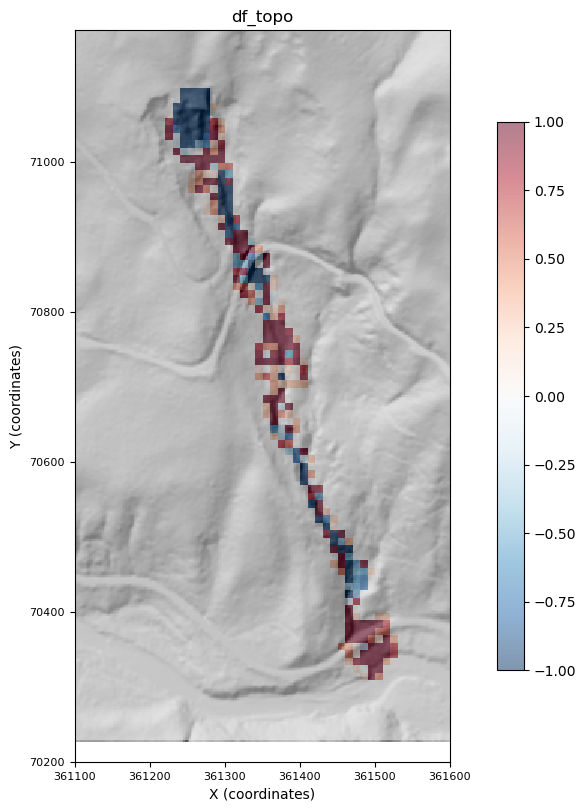

<Figure size 1200x1200 with 0 Axes>

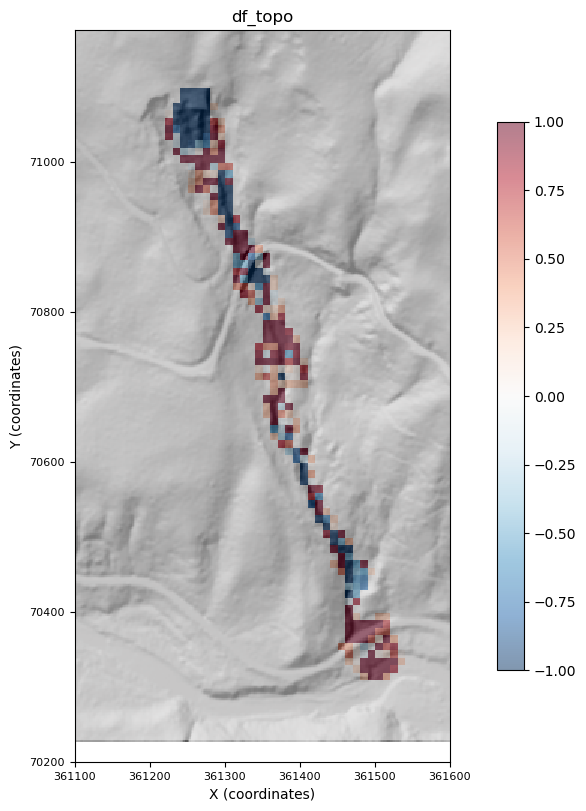

In [12]:
    imn = 1
    for i in np.arange(0,len(DebrisFlows.mw_ids)):
        for c in DebrisFlows.df_evo_maps[i].keys():
            if c%3 == 0:
                         
                plt.figure('dif'+str(c)+str(i),figsize=(12, 12))
                mg.at_node['df_topo'] = DebrisFlows.df_evo_maps[i][c]-mg.at_node['topographic__initial_elevation']
                LLT.plot_node_field_with_shaded_dem_Arc(mg, mg_hs = mg_hs, field = 'df_topo',plot_name = 'dem dif{},{}'.format(i,c), fontsize = 10,cmap = 'RdBu_r',alpha = .5)
                plt.xticks(fontsize= 8 )
                plt.yticks(fontsize= 8 )
                plt.ylim([mvx,mvx_])
                plt.xlim([mvy, mvy_])
                plt.clim(-1,1)